Focus project
step 1:

Calculate max number of starts using newton formula:

Limit to 10GB of memory and 10s of processing time for one iteration.



## Imports

In [1]:
# Imports

# From python
import math
import time
import numpy as np
import os
import multiprocessing
import traceback
from typing import Callable

# From External Libraries
from tqdm.notebook import tqdm
# import pandas as pd
from  matplotlib import pyplot as plt

# From libraries to test

## Numba
import numba
from numba import njit, prange

## Jax


## Taichi
# import taichi as ti

## Validate Acceleration

In [ ]:
def validate_acceleration( method1: Callable, method2: Callable, X: np.
ndarray ) -> bool:
    result1 = method1(X)
    result2 = method2(X)

    return np.allclose(result1, result2)

## Different Acceleration Codes

In [3]:
acceleration_functions = []

In [4]:
# Implement acceleration just using pythonic loops
def get_acceleration_naive_loops(X: np.ndarray) -> np.ndarray:
    acceleration = np.zeros(X.shape)
    for i, ri in enumerate(X):

        sum = np.zeros(3)
        for j, rj in enumerate(X):
            if i == j:
                continue
            diff = rj - ri
            cube = np.linalg.norm(diff) ** 3
            sum += diff / cube

        acceleration[i] = -sum

    return acceleration



In [5]:
# Implement using np arrays and broadcasting
def get_acceleration_numpy(X: np.ndarray) -> np.ndarray:
    vec_diff = X[:, np.newaxis] - X
    distance_matrix = np.linalg.norm(vec_diff, axis=2) ** 3

    # Set distance 0 to inf to avoid dividing by 0
    distance_matrix[distance_matrix == 0] = np.inf

    acceleration = vec_diff / distance_matrix[:, :, np.newaxis]

    return -np.sum(acceleration, axis=0)

### Numba

In [6]:
@njit
def get_acceleration_naive_loops_numba(X: np.ndarray) -> np.ndarray:
    acceleration = np.zeros(X.shape)
    for i in range(len(X)):

        sum = np.zeros(3)
        for j in range(len(X)):
            if i == j:
                continue
            diff = X[j] - X[i]
            cube = np.linalg.norm(diff) ** 3
            sum = sum + diff / cube

        acceleration[i] = -sum

    return acceleration

# Run one time to make jit compile the code
# print("Numba loops:",validate_acceleration(get_acceleration_naive_loops_numba, get_acceleration_numpy, a))



# Use the same code as above just changing range for prange and setting the njit property
@njit(parallel=True)
def get_acceleration_numba_parallel(X: np.ndarray) -> np.ndarray:
    acceleration = np.zeros(X.shape)
    for i in prange(len(X)):

        sum = np.zeros(3)
        for j in range(len(X)):
            if i == j:
                continue
            diff = X[j] - X[i]
            cube = np.linalg.norm(diff) ** 3
            sum = sum + diff / cube

        acceleration[i] = -sum

    return acceleration

# Run one time to make jit compile the code
# print("Numba parallel:",validate_acceleration(get_acceleration_numba_parallel, get_acceleration_numpy, a))



### Jax

In [39]:
import jax.numpy as jnp
import jax

# @jax.jit # Dont use the annotation to be able to compile for gpu and cpu
def get_acceleration_jax(X: np.ndarray) -> np.ndarray:
    N = len(X)

    def get_i(i):  # Kernel executed in parallel

        vec_diff = X - X[i]
        distance_matrix = jnp.linalg.norm(vec_diff, axis=1) ** 3
        acceleration = vec_diff / distance_matrix[:, jnp.newaxis]

        return -jnp.nansum(acceleration, axis=0)

    # Parallel loop using jax.vmap
    return jax.vmap(get_i)(jnp.arange(N))  # Vectorized version for parallel execution


# Ensure use of 64 bits vs the default of 32 bits
jax.config.update("jax_enable_x64", True)



# For using with gpu - run in another notebook in colab
# Colab only allows two cores so the parallelization is not effective there.
# from: https://github.com/jax-ml/jax/issues/1598#issuecomment-548031576
get_acceleration_jax_cpu = jax.jit(get_acceleration_jax, backend='cpu')
get_acceleration_jax_gpu = jax.jit(get_acceleration_jax, backend="gpu")



In [96]:
import jax.numpy as jnp
import jax
from jax import lax

@jax.jit # Dont use the annotation to be able to compile for gpu and cpu
def get_acceleration_jax2(X: np.ndarray) -> np.ndarray:
    N = len(X)

    def get_i(i):  # Kernel executed in parallel

        vec_diff = X - X[i]
        
        distance_matrix = jnp.linalg.norm(vec_diff, axis=1) ** 3
        # jax.debug.print("{x}", x=vec_diff.shape)
        acceleration = vec_diff / distance_matrix[:, jnp.newaxis]

        return -jnp.nansum(acceleration, axis=0)

    # Parallel loop using jax.vmap
    return lax.map(get_i, jnp.arange(N))  # Vectorized version for parallel execution



# Ensure use of 64 bits vs the default of 32 bits
jax.config.update("jax_enable_x64", True)



# For using with gpu - run in another notebook in colab
# Colab only allows two cores so the parallelization is not effective there.
# from: https://github.com/jax-ml/jax/issues/1598#issuecomment-548031576
# get_acceleration_jax_cpu = jax.jit(get_acceleration_jax, backend='cpu')
# get_acceleration_jax_gpu = jax.jit(get_acceleration_jax, backend="gpu")



In [111]:
test_arr = np.random.rand(64_000,3)
get_acceleration_jax2(test_arr).shape

(64000, 3)

In [82]:
validate_acceleration(get_acceleration_jax_cpu, get_acceleration_numba_parallel, np.random.rand(20,3))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


True

## Measure Functions performance

In [63]:
acceleration_functions = [
    get_acceleration_naive_loops,
    get_acceleration_numpy,
    get_acceleration_naive_loops_numba,
    get_acceleration_numba_parallel,
    get_acceleration_jax_cpu,
    # get_acceleration_jax_gpu
]
acceleration_functions_dic = {f.__name__.replace("get_acceleration_",""):f   for f in acceleration_functions}


In [59]:
import multiprocessing
import psutil
import time


# run_with_limit.py
import subprocess
import psutil
import time



def time_algorithm_with_limits(function_name: str, N: int, max_mem_mb=1024, max_time_sec=10, script_path="accelerations.py"):
    mem_limit = False
    time_limit = False

    # Start subprocess
    # print(f"Starting process {script_path}:{function_name}")
    process = subprocess.Popen(
        ["python", script_path, function_name, str(N)],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    start_time = time.time()

    proc = psutil.Process(process.pid)
    try:
        while process.poll() is None:
            mem = proc.memory_info().rss / 1024**2  # Memory in MB
            current_duration = time.time() - start_time
            if mem > max_mem_mb:
                # print(f"[!] Exceeded memory {mem}/{max_mem_mb} or time {current_duration}/{max_time_sec} Killing process.")
                process.terminate()
                mem_limit = True
                break
            # Add 5 extra secs to account for fork and array init
            if current_duration > max_time_sec + 5:
                # print(f"[!] Exceeded memory {mem}/{max_mem_mb} or time {current_duration}/{max_time_sec} Killing process.")
                process.terminate()
                time_limit = True
                break
            time.sleep(0.1)
    except psutil.NoSuchProcess:
        pass
    process.wait()
    current_duration = time.time() - start_time

    stdout, stderr = process.communicate()

    wtime = current_duration
    if not (mem_limit or time_limit):
        if process.returncode == 0:
                wtime = float(stdout.strip())
        else:
            print("")
            print(f"stdout:{stdout}")
            print(f"stderr:{stderr}")

    return wtime, mem, (time_limit, mem_limit)





In [157]:
import gc
import sys
from sys import getsizeof
def time_algorithm(algo, N):
    X = np.random.rand(N, 3)
    print(f"N:{N:_} size:{getsizeof(X)/(1024**2):.2f} MB, sizenp:{X.nbytes/(1024**2):.2f}")
    start = time.time()
    r = algo(X)
    elapsed_time = time.time() - start
    print(sys.getrefcount(r), sys.getrefcount(X))
    # r.resize((0, 0), refcheck=False) 
    # X.resize((0, 0), refcheck=False) 
    del r
    del X
    gc.collect()
    return elapsed_time


def verify_complexity(func_name, steps=20, starting_size=20):
    # algo = acceleration_functions_dic[func_name]
    wtime = []
    mem_usage = []
    stopped_arr = []

    n_values = [int(starting_size * 10 ** i) for i in range(0, steps)]
    tested_n = []
    for N in n_values:
        elapsed_time, memory_used, limits = time_algorithm_with_limits(func_name, N)
        print(f"{N}: {elapsed_time} {memory_used}")

        wtime.append(elapsed_time)
        mem_usage.append(memory_used)
        stopped_arr.append(limits)
        tested_n.append(N)
        if any(limits):
            print(f"Limits {[l for f,l in zip(limits,['time','mem']) if f]} hit: {elapsed_time} {memory_used}")
            break
    return tested_n, wtime, mem_usage




# def plot_table(n_values, wtime, algorithm_name):
#     df = pd.DataFrame({"N": n_values, "time": wtime})
#     print(f"Table for {algorithm_name} algorithm")
#     display(df)



def plot_complexity(algorithms_data):
    plt.figure(figsize=(10,10))
    for algo,(n_values, wtime, mem_usage) in algorithms_data.items():
        plt.plot(n_values[:-1], wtime[:-1], marker="o", label=algo)
        for x,y in zip(n_values, wtime):
            plt.text(x,y, f"{x:.0e}")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("N")
    plt.ylabel("log time")
    plt.grid()
    plt.legend()
    plt.title(f"Acceleration algorithm(s) complexity analysis")
    plt.show()


def plot_memory(algorithms_data):
    plt.figure(figsize=(10,10))
    for algo,(n_values, wtime, mem_usage) in algorithms_data.items():
        plt.plot(n_values, mem_usage, marker="o", label=algo)
        for x,y in zip(n_values, wtime):
            plt.text(x,y, f"{x:.0e}")
    plt.xscale("log")
    # plt.yscale("log")
    plt.xlabel("N")
    plt.ylabel("memory usage MB")
    plt.grid()
    plt.legend()
    plt.title(f"Acceleration algorithm(s) memory analysis")
    plt.show()

In [144]:
algorithms_complexity = {}
for func_name in acceleration_functions_dic:
    print(func_name)
    try:
        algorithms_complexity[func_name] = verify_complexity(
            func_name,
            steps=10,
            starting_size=10,
        )
    except Exception as e:
        print(f"{type(e).__name__}: {e}")
        print(traceback.format_exc())       


naive_loops
100: 0.023020267486572266 165.640625
1000: 2.488562822341919 166.10546875
10000: 15.049220085144043 165.4765625
Limits ['time'] hit: 15.049220085144043 165.4765625
numpy
100: 0.00046062469482421875 165.578125
1000: 0.048848867416381836 165.76953125
10000: 1.018172025680542 1176.796875
Limits ['mem'] hit: 1.018172025680542 1176.796875
naive_loops_numba
100: 0.0016322135925292969 222.87109375
1000: 0.15776848793029785 223.0234375
10000: 15.052182912826538 223.55859375
Limits ['time'] hit: 15.052182912826538 223.55859375
numba_parallel
100: 0.0004718303680419922 227.3828125
1000: 0.020238876342773438 227.45703125
10000: 3.7901339530944824 227.84765625
100000: 15.091783285140991 231.60546875
Limits ['time'] hit: 15.091783285140991 231.60546875
jax
100: 0.0005819797515869141 226.90625
1000: 0.012850284576416016 0.0
10000: 0.8680686950683594 1644.8125
Limits ['mem'] hit: 0.8680686950683594 1644.8125


In [154]:
func_name = "jax2"
algorithms_complexity[func_name+"v3"] = verify_complexity(
            func_name,
            steps=10,
            starting_size=100,
        )

100: 0.00022268295288085938 229.39453125
1000: 0.003220081329345703 226.3828125
10000: 0.47666168212890625 231.31640625
100000: 15.051685810089111 245.21875
Limits ['time'] hit: 15.051685810089111 245.21875


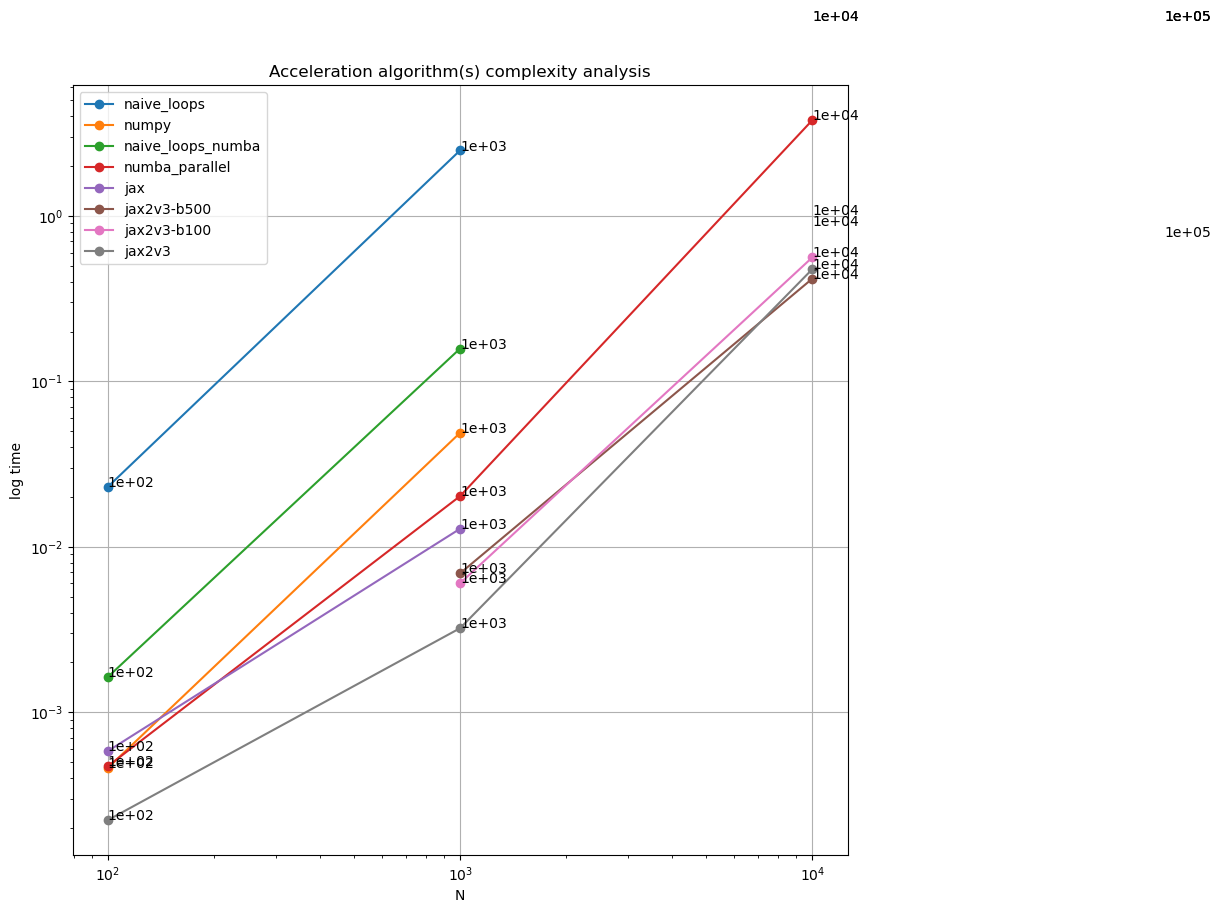

In [155]:
plot_complexity(algorithms_complexity)

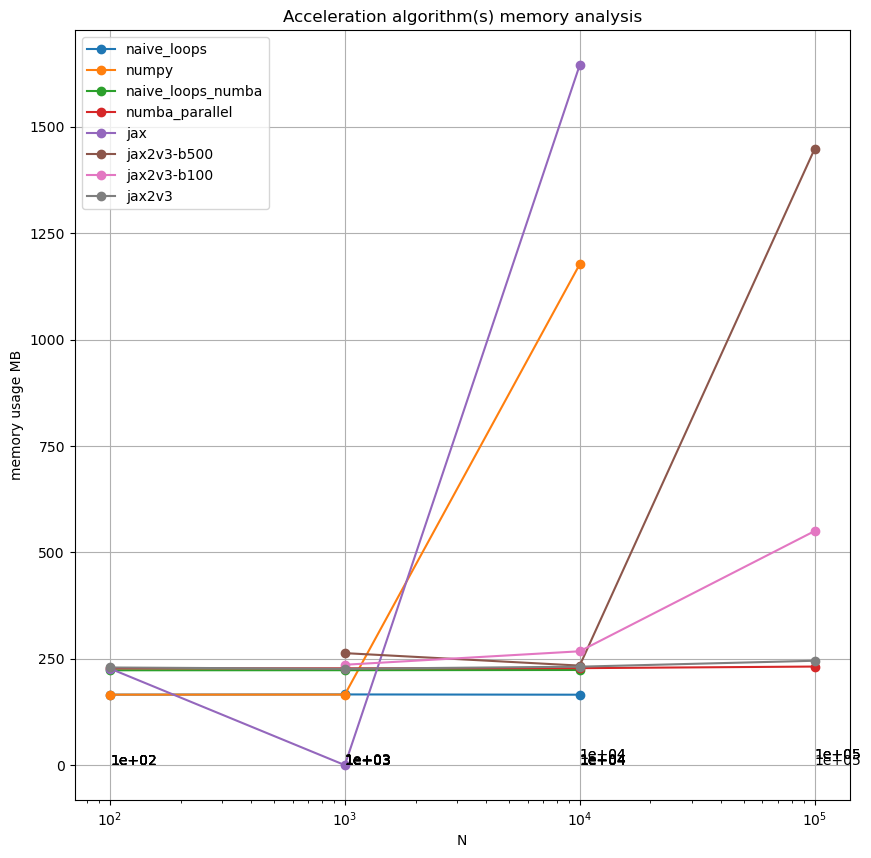

In [158]:
plot_memory(algorithms_complexity)